# Sangjun Han (Group 21)

In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm 
import sklearn.metrics as skmetrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


from prophet import Prophet

import warnings                               
warnings.filterwarnings('ignore')

## Data Cleaning

In [2]:
df = pd.read_csv('train.csv')

# Keep WindSpeed as an exog predictor for future use
subset = df[['Datetime', 'ActivePower','WindSpeed']]
subset = subset.rename(columns={"Datetime": "ds", "ActivePower": "y"})
subset['ds'] = pd.to_datetime(subset['ds']).dt.tz_localize(None)
subset_daily = subset.groupby(pd.Grouper(key='ds', freq='D')).mean()
subset_daily = subset_daily.reset_index()

# since there's only 308 NaN windspeed values but 77202 total values, we drop the NaN values 
# subset_daily.dropna(inplace=True)

subset_daily.fillna(method='ffill', inplace=True)  # Forward fill
subset_daily.fillna(method='bfill', inplace=True)  # Backward fill (can be used in combination with forward fill)

test = subset_daily.iloc[-15:]  
train = subset_daily.iloc[:-15]

In [3]:
subset_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         805 non-null    datetime64[ns]
 1   y          805 non-null    float64       
 2   WindSpeed  805 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 19.0 KB


## Visual Analysis

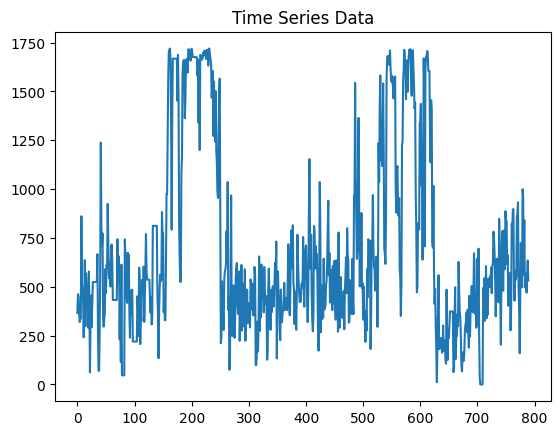

In [4]:
# time series
train['y'].plot()
plt.title('Time Series Data')
plt.show()

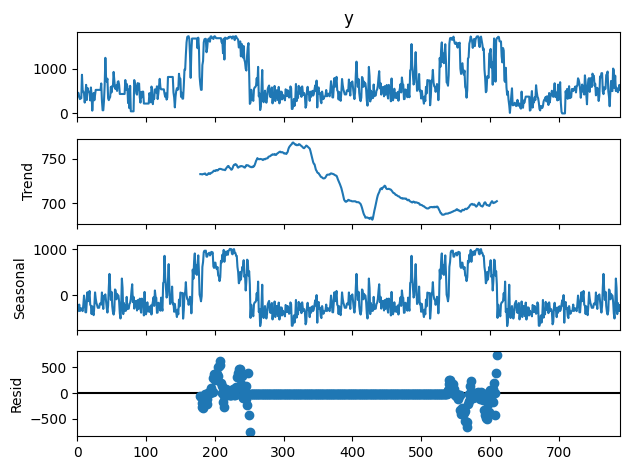

In [5]:
# Decompose the time series
result = seasonal_decompose(train['y'], model='additive', period=359) 

# Plot the decomposed components
result.plot()
plt.show()


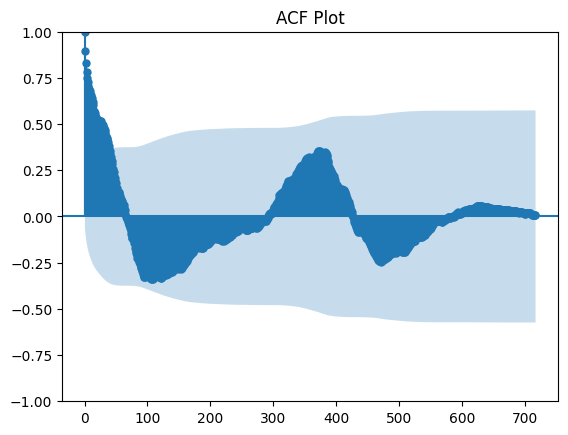

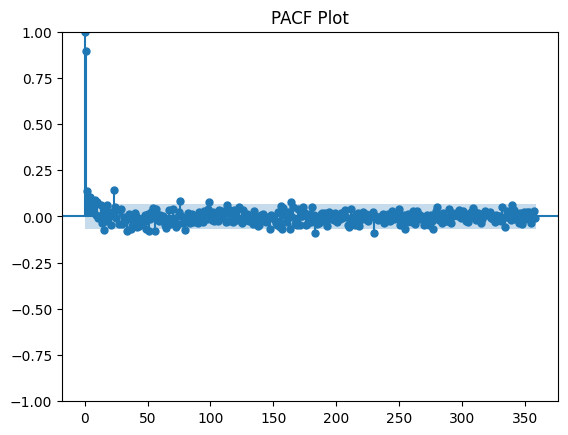

In [6]:
plot_acf(train['y'], lags=717)
plt.title('ACF Plot')
plt.show()

plot_pacf(train['y'], lags=358)
plt.title('PACF Plot')
plt.show()


Having huge peak seasonal on August

## 1. Prophet (Optimal Model)

16:34:02 - cmdstanpy - INFO - Chain [1] start processing
16:34:02 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 162.87861159347239


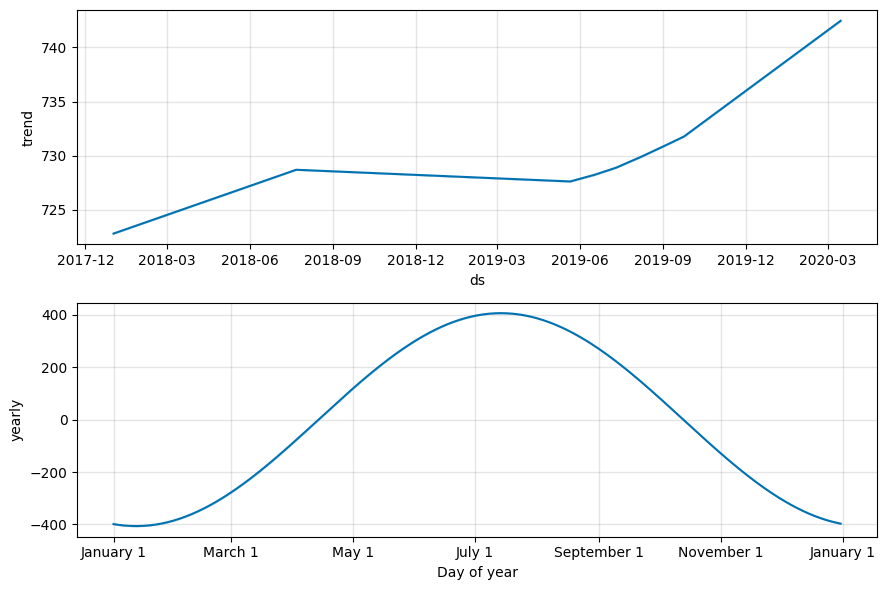

In [7]:
m = Prophet(weekly_seasonality=False, yearly_seasonality=1)
m.add_seasonality(name='yearly', period=365.25, fourier_order=5)
forecast = m.fit(train).predict(m.make_future_dataframe(periods=15))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['y'].values, forecast['yhat'][-15:]))
print('Test RMSE:', rmse)

fig = m.plot_components(forecast)

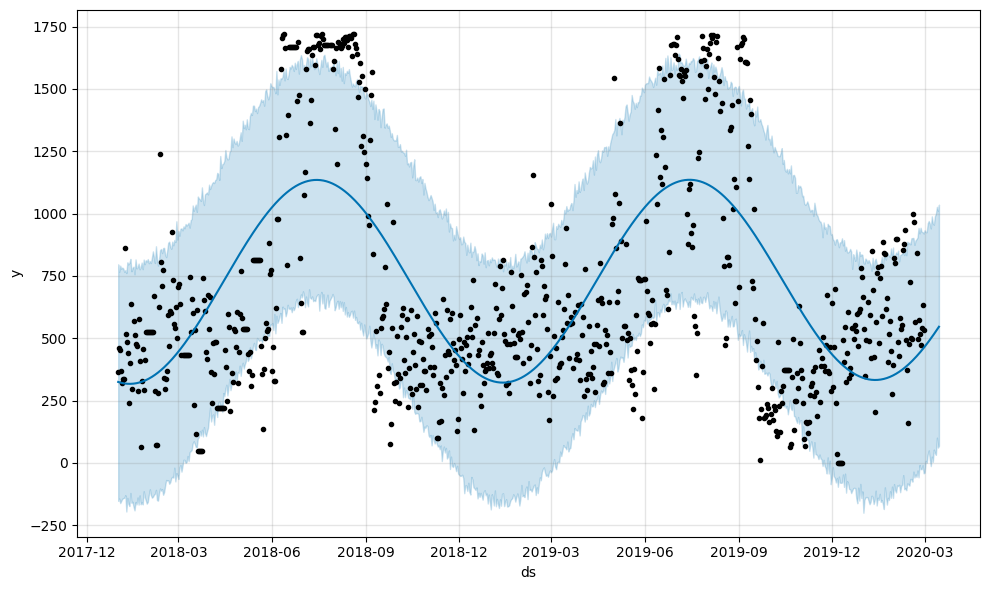

In [24]:
fig = m.plot(forecast)

This is our best model.

## 2. Simple Exponential Smoothing & Exponential Smoothing

In [8]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

best_alpha = None
best_rmse = float("inf")

for alpha in np.arange(0.1, 1.0, 0.1):
    ses_model = SimpleExpSmoothing(train['y']).fit(smoothing_level=alpha, optimized=False)
    ses_forecast = ses_model.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test['y'], ses_forecast))
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}, RMSE: {best_rmse}")


Best Alpha: 0.9, RMSE: 177.51351353035858


In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

m1 = ExponentialSmoothing(train['y'], trend="add", seasonal="add", seasonal_periods=7, damped_trend=False).fit() 
m2 = ExponentialSmoothing(train['y'], trend="add", seasonal="add", seasonal_periods=7, damped_trend=True).fit() 

pred_1 = pd.DataFrame(m1.forecast(len(test)))
pred_2 = pd.DataFrame(m2.forecast(len(test)))

In [10]:
rmse1 = np.sqrt(np.mean((test['y'].values - pred_1.values)**2))
rmse2 = np.sqrt(np.mean((test['y'].values - pred_2.values)**2))

In [11]:
print("rmse1:", rmse1)
print("rmse2:", rmse2)

rmse1: 178.95025677135357
rmse2: 178.77021918805318


## 3. LSTM

In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Normalize your data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(subset_daily[['y', 'WindSpeed']])


In [13]:
import numpy as np

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])  # Assuming the first column is the target
    return np.array(dataX), np.array(dataY)

# Use the function to create the dataset
look_back = 250  # Number of previous time steps to use as input variables
X, y = create_dataset(scaled_data, look_back)


In [14]:
train_size = len(X) - 15
test_size = 15
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.random import set_seed

# Optional: Set a random seed for reproducibility
set_seed(42)

# Build the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [16]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
17/17 - 5s - loss: 0.0497 - val_loss: 0.0124 - 5s/epoch - 268ms/step
Epoch 2/100
17/17 - 3s - loss: 0.0282 - val_loss: 0.0119 - 3s/epoch - 151ms/step
Epoch 3/100
17/17 - 3s - loss: 0.0235 - val_loss: 0.0128 - 3s/epoch - 159ms/step
Epoch 4/100
17/17 - 3s - loss: 0.0234 - val_loss: 0.0113 - 3s/epoch - 180ms/step
Epoch 5/100
17/17 - 3s - loss: 0.0223 - val_loss: 0.0103 - 3s/epoch - 176ms/step
Epoch 6/100
17/17 - 3s - loss: 0.0208 - val_loss: 0.0116 - 3s/epoch - 182ms/step
Epoch 7/100
17/17 - 3s - loss: 0.0215 - val_loss: 0.0100 - 3s/epoch - 173ms/step
Epoch 8/100
17/17 - 3s - loss: 0.0197 - val_loss: 0.0108 - 3s/epoch - 183ms/step
Epoch 9/100
17/17 - 3s - loss: 0.0198 - val_loss: 0.0116 - 3s/epoch - 186ms/step
Epoch 10/100
17/17 - 3s - loss: 0.0194 - val_loss: 0.0100 - 3s/epoch - 180ms/step
Epoch 11/100
17/17 - 3s - loss: 0.0188 - val_loss: 0.0100 - 3s/epoch - 192ms/step
Epoch 12/100
17/17 - 3s - loss: 0.0188 - val_loss: 0.0099 - 3s/epoch - 188ms/step
Epoch 13/100
17/17 - 3s -

In [17]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict_padded = np.concatenate((train_predict, np.zeros((len(train_predict), 1))), axis=1)
test_predict_padded = np.concatenate((test_predict, np.zeros((len(test_predict), 1))), axis=1)

# Invert scaling for predictions
train_predict_inv = scaler.inverse_transform(train_predict_padded)[:, 0]  # Get the first column
test_predict_inv = scaler.inverse_transform(test_predict_padded)[:, 0]    # Get the first column

# Invert scaling for actual target values
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((len(y_train), 1))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 1))), axis=1))[:, 0]

1/1 [==============================] - 0s 31ms/step


In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

test_rmse = sqrt(mean_squared_error(y_test_inv, test_predict_inv))
print(f'Test RMSE: {test_rmse}')


Test RMSE: 182.5990288975116


## 4. SARIMAX (exog) + LSTM: Best RMSE but Overfitting with exog

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare data
train_y = train['y']
train_X = train[['WindSpeed']]  # Exogenous variable

# Fit SARIMA model
sarima_model = SARIMAX(train_y, exog=train_X, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()

# Predict using SARIMA
sarima_preds = sarima_model.predict(start=train.index[0], end=train.index[-1], exog=train_X)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97703D+00    |proj g|=  5.86688D-02

At iterate    5    f=  5.93689D+00    |proj g|=  1.55931D-02

At iterate   10    f=  5.79705D+00    |proj g|=  1.73073D-01

At iterate   15    f=  5.77708D+00    |proj g|=  7.71334D-04

At iterate   20    f=  5.77668D+00    |proj g|=  1.94352D-02

At iterate   25    f=  5.77498D+00    |proj g|=  3.65650D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     36      1     0     0   

In [20]:
residuals = train_y - sarima_preds

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Scale the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Function to convert series to supervised learning
def create_dataset(dataset, look_back=7):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Use the function to create the dataset for LSTM
X, y = create_dataset(scaled_residuals, look_back=7)

# Split into train and test sets for LSTM
train_size = len(X) - 15
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(1, 7)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Predict using LSTM on residuals
lstm_preds = model.predict(X_test)
lstm_preds = scaler.inverse_transform(lstm_preds)  # Inverse scaling


Epoch 1/100
768/768 - 1s - loss: 0.0085 - 718ms/epoch - 935us/step
Epoch 2/100
768/768 - 0s - loss: 0.0040 - 309ms/epoch - 402us/step
Epoch 3/100
768/768 - 0s - loss: 0.0039 - 306ms/epoch - 399us/step
Epoch 4/100
768/768 - 0s - loss: 0.0038 - 307ms/epoch - 399us/step
Epoch 5/100
768/768 - 0s - loss: 0.0037 - 308ms/epoch - 402us/step
Epoch 6/100
768/768 - 0s - loss: 0.0037 - 308ms/epoch - 401us/step
Epoch 7/100
768/768 - 0s - loss: 0.0036 - 307ms/epoch - 400us/step
Epoch 8/100
768/768 - 0s - loss: 0.0037 - 306ms/epoch - 399us/step
Epoch 9/100
768/768 - 0s - loss: 0.0036 - 307ms/epoch - 400us/step
Epoch 10/100
768/768 - 0s - loss: 0.0036 - 305ms/epoch - 397us/step
Epoch 11/100
768/768 - 0s - loss: 0.0036 - 308ms/epoch - 402us/step
Epoch 12/100
768/768 - 0s - loss: 0.0034 - 307ms/epoch - 400us/step
Epoch 13/100
768/768 - 0s - loss: 0.0035 - 308ms/epoch - 401us/step
Epoch 14/100
768/768 - 0s - loss: 0.0036 - 308ms/epoch - 401us/step
Epoch 15/100
768/768 - 0s - loss: 0.0035 - 309ms/epoch - 

In [23]:
# SARIMA forecast for the test period
test_X = test[['WindSpeed']]
sarima_test_forecast = sarima_model.forecast(steps=15, exog=test_X)

# Add the LSTM predictions of the residuals to SARIMA forecasts
final_forecast = sarima_test_forecast + lstm_preds[:15].flatten()

# Calculate RMSE
rmse = sqrt(mean_squared_error(test['y'].values, final_forecast))
print('Test RMSE:', rmse)

Test RMSE: 59.031188455893634


I think this is overfitting with exog variable. We have to separately run the additional regressor. 